In [108]:
# importing all the modules we will need in this project.
import pandas as pd
import numpy as np
from datetime import datetime
from math import sin, cos, acos, pi
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import warnings

warnings.filterwarnings('ignore')

## Data Exploration

We start off by reading our csv files, and getting to know about the shape of our Dataframes, their structure, check for duplicates or null values and alterations we need to make in order to be able to exploit them properly.

In [2]:
cities = pd.read_csv("./data/cities.csv")
providers = pd.read_csv("./data/providers.csv")
stations = pd.read_csv("./data/stations.csv")
ticket = pd.read_csv("./data/ticket_data.csv")

In [3]:
print("Cities data shape = ", cities.shape)
print("Providers data shape = ", providers.shape)
print("Stations data shape = ", stations.shape)
print("Tickets data shape = ", ticket.shape)

Cities data shape =  (8040, 6)
Providers data shape =  (227, 10)
Stations data shape =  (11035, 4)
Tickets data shape =  (74168, 12)


* Cities dataframe:

In [4]:
cities.head()

id                     local_name unique_name   latitude  longitude  \
0   5159          Padua, Veneto, Italia       padua  45.406435  11.876761   
1     76    Barcelona, Cataluña, España   barcelona  41.385064   2.173404   
2     81    Basel, Basel-Stadt, Schweiz       basel  47.593437   7.619812   
3    259  Erlangen, Bayern, Deutschland    erlangen  49.589674  11.011961   
4  11979             Balș, Olt, România        balș  44.353354  24.095672   

   population  
0    209678.0  
1   1611822.0  
2         NaN  
3    105412.0  
4         NaN

In [5]:
cities["unique_name"].value_counts()

montoir-de-bretagne     1
metzing                 1
st.-clears              1
frick                   1
halsou-larressore       1
                       ..
eauze                   1
patti-s-piero-patti     1
golfe-juan-vallauris    1
lermoos                 1
smokovic                1
Name: unique_name, Length: 8039, dtype: int64

In [6]:
cities.describe()

id     latitude    longitude    population
count   8040.000000  8040.000000  8040.000000  3.690000e+02
mean    6328.786816    47.223456     6.299331  3.360184e+05
std     3504.698537     3.700934     7.747070  5.840409e+05
min        1.000000     1.370676  -101.397388  1.000460e+05
25%     2501.500000    44.662402     1.214282  1.253750e+05
50%     7003.500000    47.304750     4.887856  1.803020e+05
75%     9014.250000    49.611998    10.311597  3.098690e+05
max    12192.000000    64.145981    48.731938  8.416535e+06

In [7]:
cities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8040 entries, 0 to 8039
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           8040 non-null   int64  
 1   local_name   8040 non-null   object 
 2   unique_name  8039 non-null   object 
 3   latitude     8040 non-null   float64
 4   longitude    8040 non-null   float64
 5   population   369 non-null    float64
dtypes: float64(3), int64(1), object(2)
memory usage: 377.0+ KB


In [8]:
cities[cities["unique_name"].isnull()]

id              local_name unique_name   latitude  longitude  \
6866  10244  , Hamburg, Deutschland         NaN  39.613402   2.880431   

      population  
6866         NaN

In [9]:
cities[cities["unique_name"]=="hamburg"]

id                     local_name unique_name   latitude  longitude  \
5036  336  Hamburg, Hamburg, Deutschland     hamburg  53.551085   9.993682   

      population  
5036   1787408.0

In [10]:
occ_hamburg1 = len(ticket[ticket["o_city"]==10244])+ len(ticket[ticket["d_city"]==10244])
occ_hamburg2 = len(ticket[ticket["o_city"]==336])+ len(ticket[ticket["d_city"]==336])

print("There are %s occurences of the city of hamburg with the id 10244" %occ_hamburg1)
print("There are %s occurences of the city of hamburg with the id 336" %occ_hamburg2)

There are 0 occurences of the city of hamburg with the id 10244
There are 38 occurences of the city of hamburg with the id 336


In [11]:
print("old shape = ",cities.shape)
cities.dropna(subset=["unique_name"], inplace=True)
print("new shape = ",cities.shape)


old shape =  (8040, 6)
new shape =  (8039, 6)


* Providers dataframe:

In [12]:
providers.head(10)

id  company_id provider_id               name            fullname has_wifi  \
0   9           1         NaN             ouibus              Ouibus     True   
1  10           2         NaN            deinbus          Deinbus.de    False   
2  11           3         NaN            infobus             Infobus    False   
3  12           4         NaN      studentAgency      Student Agency    False   
4  13           5         NaN            flixbus             Flixbus     True   
5  14           6         NaN            driivme            DriiveMe    False   
6  15           8         NaN               alsa                Alsa    False   
7  16           9         NaN       distribusion        Distribusion    False   
8  17           9          31  expressbusMunchen  Expressbus Munchen    False   
9  18           9          33    berlinLinienBus   Berlin Linien Bus    False   

  has_plug has_adjustable_seats has_bicycle transport_type  
0     True                 True       False            bus  
1    False                False       False            bus  
2    False                False       False            bus  
3    False                False       False            bus  
4    False                False       False            bus  
5    False                False       False            car  
6    False                False       False            bus  
7    False                False       False            bus  
8    False                False       False            bus  
9    False                False       False            bus

In [13]:
providers[providers["id"]==8385]

id  company_id provider_id name   fullname has_wifi has_plug  \
223  8385          11         NaN  bbc  Blablacar    False    False   

    has_adjustable_seats has_bicycle transport_type  
223                False       False     carpooling

In [14]:
providers.describe()

id  company_id
count   227.000000  227.000000
mean    790.656388    9.343612
std    2251.823950    3.036065
min       9.000000    1.000000
25%      66.500000    9.000000
50%     127.000000    9.000000
75%     183.500000    9.000000
max    8389.000000   40.000000

In [15]:
providers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227 entries, 0 to 226
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    227 non-null    int64 
 1   company_id            227 non-null    int64 
 2   provider_id           213 non-null    object
 3   name                  227 non-null    object
 4   fullname              227 non-null    object
 5   has_wifi              224 non-null    object
 6   has_plug              224 non-null    object
 7   has_adjustable_seats  224 non-null    object
 8   has_bicycle           224 non-null    object
 9   transport_type        227 non-null    object
dtypes: int64(2), object(8)
memory usage: 17.9+ KB


* Stations dataframe:

In [16]:
stations.head()

id                     unique_name   latitude  longitude
0   1      Aalen (Stuttgarter Straße)  48.835296  10.092956
1   2      Aéroport Bordeaux-Mérignac  44.830226  -0.700883
2   3                   Aéroport CDG   49.009900   2.559310
3   4  Aéroport de Berlin-Schönefeld   52.389446  13.520345
4   5             Aéroport de Dresden  51.123604  13.764737

In [17]:
stations.describe()

id      latitude     longitude
count  11035.000000  11035.000000  11035.000000
mean    5518.026914     47.526678      7.580807
std     3185.719813      3.953972     63.655681
min        1.000000    -22.355790    -22.625538
25%     2759.500000     44.896446      1.358655
50%     5518.000000     47.759670      5.824010
75%     8276.500000     50.349956     12.166133
max    11036.000000     64.137571   6645.000000

In [18]:
stations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11035 entries, 0 to 11034
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           11035 non-null  int64  
 1   unique_name  11035 non-null  object 
 2   latitude     11035 non-null  float64
 3   longitude    11035 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 345.0+ KB


* Ticket dataframe:

In [19]:
ticket.head()

id  company  o_station  d_station            departure_ts  \
0  6795025     8385        NaN        NaN  2017-10-13 14:00:00+00   
1  6795026        9       63.0     1044.0  2017-10-13 13:05:00+00   
2  6795027     8377     5905.0     6495.0  2017-10-13 13:27:00+00   
3  6795028     8377     5905.0     6495.0  2017-10-13 13:27:00+00   
4  6795029     8381     5905.0     6495.0  2017-10-13 21:46:00+00   

               arrival_ts  price_in_cents                   search_ts  \
0  2017-10-13 20:10:00+00            4550  2017-10-01 00:13:31.327+00   
1  2017-10-14 06:55:00+00            1450  2017-10-01 00:13:35.773+00   
2  2017-10-14 21:24:00+00            7400  2017-10-01 00:13:40.212+00   
3  2017-10-14 11:02:00+00           13500  2017-10-01 00:13:40.213+00   
4  2017-10-14 19:32:00+00            7710  2017-10-01 00:13:40.213+00   

       middle_stations other_companies  o_city  d_city  
0                  NaN             NaN     611     542  
1            {149,418}            {13}     611     542  
2  {798,798,6794,6246}     {8377,8376}     611     542  
3  {798,798,6794,6246}     {8377,8376}     611     542  
4          {5983,5983}          {8380}     611     542

In [20]:
ticket.describe()

id       company     o_station     d_station  price_in_cents  \
count  7.416800e+04  74168.000000  32727.000000  32727.000000    74168.000000   
mean   6.832108e+06   7109.565527   2907.132673   2347.858129     4382.711061   
std    2.141060e+04   3005.380792   3347.629180   3090.798007     3739.325367   
min    6.795025e+06      9.000000      3.000000      3.000000      300.000000   
25%    6.813567e+06   8376.000000    400.000000    396.000000     1900.000000   
50%    6.832108e+06   8385.000000    701.000000    575.000000     3350.000000   
75%    6.850650e+06   8385.000000   6246.000000   4538.000000     5250.000000   
max    6.869192e+06   8387.000000  11017.000000  11017.000000    38550.000000   

             o_city        d_city  
count  74168.000000  74168.000000  
mean     849.186105    883.776265  
std     1485.791782   1654.698575  
min        5.000000      1.000000  
25%      485.000000    453.000000  
50%      628.000000    562.000000  
75%      628.000000    628.000000  
max    12190.000000  12190.000000

In [21]:
ticket.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74168 entries, 0 to 74167
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               74168 non-null  int64  
 1   company          74168 non-null  int64  
 2   o_station        32727 non-null  float64
 3   d_station        32727 non-null  float64
 4   departure_ts     74168 non-null  object 
 5   arrival_ts       74168 non-null  object 
 6   price_in_cents   74168 non-null  int64  
 7   search_ts        74168 non-null  object 
 8   middle_stations  32727 non-null  object 
 9   other_companies  32727 non-null  object 
 10  o_city           74168 non-null  int64  
 11  d_city           74168 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 6.8+ MB


We notice in here that for o_station, d_station, middle_station and other_companies we only have 32727/74168 non-null values. Let's dig into that to see if we should drop the null rows or if it is something coherent in the data despite the null values.

In [22]:
ticket[ticket["o_station"].isnull()].company.value_counts()

8385    41441
Name: company, dtype: int64

In [23]:
providers[providers["id"]==8385].fullname

223    Blablacar
Name: fullname, dtype: object

It appears that for those null values, everything makes sense since it is carpooling data and for these kind of trips there's no origin/destination/middle stations.

In [24]:
ticket.where(ticket["o_city"]==611).dropna().where(ticket["d_city"]==585).dropna().head()

id  company  o_station  d_station            departure_ts  \
62883  6857908.0   8371.0      964.0      867.0  2017-10-30 01:00:00+00   
62884  6857909.0      9.0       63.0      867.0  2017-10-30 13:05:00+00   
62885  6857910.0   8377.0     5905.0     6649.0  2017-10-30 13:30:00+00   
62886  6857911.0   8377.0     5905.0     6649.0  2017-10-30 13:30:00+00   
62887  6857912.0   8377.0     5905.0     6649.0  2017-10-30 20:11:00+00   

                   arrival_ts  price_in_cents                   search_ts  \
62883  2017-10-30 18:15:00+00          4100.0  2017-10-17 09:16:27.343+00   
62884  2017-11-01 07:55:00+00          4490.0  2017-10-17 09:16:27.343+00   
62885  2017-10-31 17:58:00+00          5810.0  2017-10-17 09:16:27.861+00   
62886  2017-10-31 17:58:00+00          6830.0  2017-10-17 09:16:27.862+00   
62887  2017-10-31 17:58:00+00          7270.0  2017-10-17 09:16:27.862+00   

                      middle_stations   other_companies  o_city  d_city  
62883                     {1044,1044}              {13}   611.0   585.0  
62884                       {149,418}              {13}   611.0   585.0  
62885             {798,798,4628,4628}       {8380,8377}   611.0   585.0  
62886  {798,6483,7131,7131,4283,4283}  {8380,8380,8377}   611.0   585.0  
62887             {798,798,4628,4628}       {8380,8377}   611.0   585.0

In order to have more exploitable features, we are going to write functions to:
* Compute Travel Time from departure and arrival features.
* Compute number of stops during each trip from the middle stations feature.
* Compute number of companies from the other_companies feature.
* Compute the distance between two cities involved in the same trip.

In [25]:
# define a function that will compute a single travel time
def computeTravelTime(dep,arr,form):
    # string conversion to datetime
    arr_conv = datetime.strptime(arr,form) 
    dep_conv = datetime.strptime(dep,form)
    tt = (arr_conv - dep_conv).total_seconds()
    return tt

In [26]:
# define a function that will compute all travel times
def computeAllTravelTime(dep_list, arr_list):
    tts = []
    for i in range(len(arr_list)):
        tt = computeTravelTime(dep_list[i][:-3],arr_list[i][:-3],"%Y-%m-%d %H:%M:%S")
        tts.append(tt)
    return tts

In [27]:
tts = computeAllTravelTime(ticket["departure_ts"].values, ticket["arrival_ts"].values)
ticket["travel_time"] = tts

In [28]:
ticket.drop(columns=["arrival_ts","departure_ts"],inplace = True)
ticket.head()

id  company  o_station  d_station  price_in_cents  \
0  6795025     8385        NaN        NaN            4550   
1  6795026        9       63.0     1044.0            1450   
2  6795027     8377     5905.0     6495.0            7400   
3  6795028     8377     5905.0     6495.0           13500   
4  6795029     8381     5905.0     6495.0            7710   

                    search_ts      middle_stations other_companies  o_city  \
0  2017-10-01 00:13:31.327+00                  NaN             NaN     611   
1  2017-10-01 00:13:35.773+00            {149,418}            {13}     611   
2  2017-10-01 00:13:40.212+00  {798,798,6794,6246}     {8377,8376}     611   
3  2017-10-01 00:13:40.213+00  {798,798,6794,6246}     {8377,8376}     611   
4  2017-10-01 00:13:40.213+00          {5983,5983}          {8380}     611   

   d_city  travel_time  
0     542      22200.0  
1     542      64200.0  
2     542     115020.0  
3     542      77700.0  
4     542      78360.0

In [29]:
ticket.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74168 entries, 0 to 74167
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               74168 non-null  int64  
 1   company          74168 non-null  int64  
 2   o_station        32727 non-null  float64
 3   d_station        32727 non-null  float64
 4   price_in_cents   74168 non-null  int64  
 5   search_ts        74168 non-null  object 
 6   middle_stations  32727 non-null  object 
 7   other_companies  32727 non-null  object 
 8   o_city           74168 non-null  int64  
 9   d_city           74168 non-null  int64  
 10  travel_time      74168 non-null  float64
dtypes: float64(3), int64(5), object(3)
memory usage: 6.2+ MB


In [30]:
len(ticket[ticket["o_city"]==10244])

0

In [31]:
# Define a function that returns the latitude and longitude in radian
def deg2rad(dd):
    return dd/180*pi

In [32]:
# Define a function that returns the distance from the longitude and latitude of two cities
def computeDistance(latA,latB,longA,longB):
    S = acos(sin(deg2rad(latA))*sin(deg2rad(latB)) + cos(deg2rad(latA))*cos(deg2rad(latB))*cos(abs(deg2rad(longB)-deg2rad(longA))))
    return 6378*S


In [33]:
liste = ["id","latitude","longitude"]
ticket = ticket.join(cities[liste].set_index("id"), on="o_city")
ticket = ticket.join(cities[liste].set_index("id"), on="d_city", rsuffix="_city_destination")
ticket = ticket.rename(columns={"latitude": "latitude_city_origin", "longitude": "longitude_city_origin"})

In [34]:
lat_o = ticket["latitude_city_origin"].values
long_o = ticket["longitude_city_origin"].values
lat_d = ticket["latitude_city_destination"].values
long_d = ticket["longitude_city_destination"].values
dist = []

for i in range(len(lat_o)):
    d = computeDistance(lat_o[i],lat_d[i],long_o[i],long_d[i])
    dist.append(d)

ticket["distance"] = dist

In [35]:
ticket.head()

id  company  o_station  d_station  price_in_cents  \
0  6795025     8385        NaN        NaN            4550   
1  6795026        9       63.0     1044.0            1450   
2  6795027     8377     5905.0     6495.0            7400   
3  6795028     8377     5905.0     6495.0           13500   
4  6795029     8381     5905.0     6495.0            7710   

                    search_ts      middle_stations other_companies  o_city  \
0  2017-10-01 00:13:31.327+00                  NaN             NaN     611   
1  2017-10-01 00:13:35.773+00            {149,418}            {13}     611   
2  2017-10-01 00:13:40.212+00  {798,798,6794,6246}     {8377,8376}     611   
3  2017-10-01 00:13:40.213+00  {798,798,6794,6246}     {8377,8376}     611   
4  2017-10-01 00:13:40.213+00          {5983,5983}          {8380}     611   

   d_city  travel_time  latitude_city_origin  longitude_city_origin  \
0     542      22200.0             47.907018                1.90627   
1     542      64200.0             47.907018                1.90627   
2     542     115020.0             47.907018                1.90627   
3     542      77700.0             47.907018                1.90627   
4     542      78360.0             47.907018                1.90627   

   latitude_city_destination  longitude_city_destination    distance  
0                  43.604452                    3.918318  503.750044  
1                  43.604452                    3.918318  503.750044  
2                  43.604452                    3.918318  503.750044  
3                  43.604452                    3.918318  503.750044  
4                  43.604452                    3.918318  503.750044

In [36]:
# Define a function that would allow us to compute the number of stops and companies involved in each trip.
def computeNumber(tocompute):
    number_of = []
    for i in range(len(tocompute)):
        value=tocompute[i]
        if pd.isna(value):
            number_of.append(0)
        else:    
            set_to_compute = set([int(s) for s in value[1:-1].split(",") if s.isdigit()])
            number_of.append(len(set_to_compute))
    return number_of

In [37]:
number_of_stops = computeNumber(ticket["middle_stations"].values)
number_of_companies = [x+1 for x in computeNumber(ticket["other_companies"].values)]
ticket["number_of_stops"] = number_of_stops
ticket["number_of_companies"] = number_of_companies


In [38]:
ticket.head()

id  company  o_station  d_station  price_in_cents  \
0  6795025     8385        NaN        NaN            4550   
1  6795026        9       63.0     1044.0            1450   
2  6795027     8377     5905.0     6495.0            7400   
3  6795028     8377     5905.0     6495.0           13500   
4  6795029     8381     5905.0     6495.0            7710   

                    search_ts      middle_stations other_companies  o_city  \
0  2017-10-01 00:13:31.327+00                  NaN             NaN     611   
1  2017-10-01 00:13:35.773+00            {149,418}            {13}     611   
2  2017-10-01 00:13:40.212+00  {798,798,6794,6246}     {8377,8376}     611   
3  2017-10-01 00:13:40.213+00  {798,798,6794,6246}     {8377,8376}     611   
4  2017-10-01 00:13:40.213+00          {5983,5983}          {8380}     611   

   d_city  travel_time  latitude_city_origin  longitude_city_origin  \
0     542      22200.0             47.907018                1.90627   
1     542      64200.0             47.907018                1.90627   
2     542     115020.0             47.907018                1.90627   
3     542      77700.0             47.907018                1.90627   
4     542      78360.0             47.907018                1.90627   

   latitude_city_destination  longitude_city_destination    distance  \
0                  43.604452                    3.918318  503.750044   
1                  43.604452                    3.918318  503.750044   
2                  43.604452                    3.918318  503.750044   
3                  43.604452                    3.918318  503.750044   
4                  43.604452                    3.918318  503.750044   

   number_of_stops  number_of_companies  
0                0                    1  
1                2                    2  
2                3                    3  
3                3                    3  
4                1                    2

In [39]:
providers[providers["has_plug"].isna()]

id  company_id provider_id      name  fullname has_wifi has_plug  \
212  8374          20         NaN  transdev  Transdev      NaN      NaN   
224  8387          30         NaN     vatry     Vatry      NaN      NaN   
225  8388          40         NaN   beauval   Beauval      NaN      NaN   

    has_adjustable_seats has_bicycle transport_type  
212                  NaN         NaN            bus  
224                  NaN         NaN            bus  
225                  NaN         NaN            bus

In [40]:
companies = []
for i in range(len(ticket["other_companies"].values)):
    if not(pd.isna(ticket["other_companies"].values[i])):   
        c = [int(s) for s in ticket["other_companies"].values[i][1:-1].split(",") if s.isdigit()]
        for element in c:
            companies.append(element)
transdev = companies.count(8374)
vatry = companies.count(8387)
beauval = companies.count(8388)

print("Number of trips involving Transdev: ",ticket[ticket["company"]==8374].count()[0]+transdev)
print("Number of trips involving Vatry: ",ticket[ticket["company"]==8387].count()[0]+vatry)
print("Number of trips involving Beauval: ",ticket[ticket["company"]==8388].count()[0]+beauval)

Number of trips involving Transdev:  0
Number of trips involving Vatry:  48
Number of trips involving Beauval:  0


In [41]:
# Drop Transdev et Beauval and keep Vatry
# Since we have only one row to fill, we are going to fill it manually (we will assume it has the same features as Navette de Vatry)
providers.loc[providers["id"]==8387,"has_wifi"] = False
providers.loc[providers["id"]==8387,"has_plug"] = True
providers.loc[providers["id"]==8387,"has_adjustable_seats"] = True
providers.loc[providers["id"]==8387,"has_bicycle"] = False

providers[providers["id"]==8387]

id  company_id provider_id   name fullname has_wifi has_plug  \
224  8387          30         NaN  vatry    Vatry    False     True   

    has_adjustable_seats has_bicycle transport_type  
224                 True       False            bus

In [42]:
ticket.head()

id  company  o_station  d_station  price_in_cents  \
0  6795025     8385        NaN        NaN            4550   
1  6795026        9       63.0     1044.0            1450   
2  6795027     8377     5905.0     6495.0            7400   
3  6795028     8377     5905.0     6495.0           13500   
4  6795029     8381     5905.0     6495.0            7710   

                    search_ts      middle_stations other_companies  o_city  \
0  2017-10-01 00:13:31.327+00                  NaN             NaN     611   
1  2017-10-01 00:13:35.773+00            {149,418}            {13}     611   
2  2017-10-01 00:13:40.212+00  {798,798,6794,6246}     {8377,8376}     611   
3  2017-10-01 00:13:40.213+00  {798,798,6794,6246}     {8377,8376}     611   
4  2017-10-01 00:13:40.213+00          {5983,5983}          {8380}     611   

   d_city  travel_time  latitude_city_origin  longitude_city_origin  \
0     542      22200.0             47.907018                1.90627   
1     542      64200.0             47.907018                1.90627   
2     542     115020.0             47.907018                1.90627   
3     542      77700.0             47.907018                1.90627   
4     542      78360.0             47.907018                1.90627   

   latitude_city_destination  longitude_city_destination    distance  \
0                  43.604452                    3.918318  503.750044   
1                  43.604452                    3.918318  503.750044   
2                  43.604452                    3.918318  503.750044   
3                  43.604452                    3.918318  503.750044   
4                  43.604452                    3.918318  503.750044   

   number_of_stops  number_of_companies  
0                0                    1  
1                2                    2  
2                3                    3  
3                3                    3  
4                1                    2

In [43]:
liste = ["id","has_wifi","fullname","has_plug","has_adjustable_seats","has_bicycle","transport_type"]
ticket = ticket.join(providers[liste].set_index("id"), on="company")
# ticket = ticket.join(cities[liste].set_index("id"), on="d_city", rsuffix="_city_destination")
# ticket = ticket.rename(columns={"latitude": "latitude_city_origin", "longitude": "longitude_city_origin"})

In [44]:
ticket.head()

id  company  o_station  d_station  price_in_cents  \
0  6795025     8385        NaN        NaN            4550   
1  6795026        9       63.0     1044.0            1450   
2  6795027     8377     5905.0     6495.0            7400   
3  6795028     8377     5905.0     6495.0           13500   
4  6795029     8381     5905.0     6495.0            7710   

                    search_ts      middle_stations other_companies  o_city  \
0  2017-10-01 00:13:31.327+00                  NaN             NaN     611   
1  2017-10-01 00:13:35.773+00            {149,418}            {13}     611   
2  2017-10-01 00:13:40.212+00  {798,798,6794,6246}     {8377,8376}     611   
3  2017-10-01 00:13:40.213+00  {798,798,6794,6246}     {8377,8376}     611   
4  2017-10-01 00:13:40.213+00          {5983,5983}          {8380}     611   

   d_city  ...  longitude_city_destination    distance  number_of_stops  \
0     542  ...                    3.918318  503.750044                0   
1     542  ...                    3.918318  503.750044                2   
2     542  ...                    3.918318  503.750044                3   
3     542  ...                    3.918318  503.750044                3   
4     542  ...                    3.918318  503.750044                1   

   number_of_companies  has_wifi            fullname  has_plug  \
0                    1     False           Blablacar     False   
1                    2      True              Ouibus      True   
2                    3     False          Intercités     False   
3                    3     False          Intercités     False   
4                    2     False  Intercités de Nuit     False   

   has_adjustable_seats has_bicycle transport_type  
0                 False       False     carpooling  
1                  True       False            bus  
2                  True       False          train  
3                  True       False          train  
4                  True       False          train  

[5 rows x 24 columns]

## Modeling : (Price, Transport Type)

## Regression

In this section, we will try to have our models predict the price of each trip given the features selected. 
* price_in_cents will be our target here which is a float value so we will be dealing with a Regression Problem. <br>


We will be trying XGBoost, Random Forrest and SVR algorithms.


In [55]:
# feature selection from the ticket dataframe
features = ["price_in_cents","travel_time","distance","o_city","d_city","number_of_stops","number_of_companies","has_wifi","has_plug","has_adjustable_seats","has_bicycle","transport_type"]
modeling_df = ticket[features]

# encoding the categorical values
le = preprocessing.LabelEncoder()

modeling_df["has_wifi"] = le.fit_transform(modeling_df["has_wifi"])
modeling_df["has_adjustable_seats"] = le.fit_transform(modeling_df["has_adjustable_seats"])
modeling_df["has_bicycle"] = le.fit_transform(modeling_df["has_bicycle"])
modeling_df["has_plug"] = le.fit_transform(modeling_df["has_plug"])
modeling_df["transport_type"] = le.fit_transform(modeling_df["transport_type"])

# for the regression problem, we are going to take "price_in_cents" as the target(Y) and the rest as our features(X) 
# and we are going to split the data to train and test data(80%,20%)
X = modeling_df.drop(columns="price_in_cents")
Y = modeling_df["price_in_cents"]
x_train, x_valid, y_train, y_valid = train_test_split(X,Y, 
                                                  random_state=29, 
                                                  test_size=0.2, shuffle=True)
print("Modeling df shape = ",modeling_df.shape)
print("Train data shape = ",x_train.shape)
print("Validation data shape = ",x_valid.shape)


Modeling df shape =  (74168, 12)
Train data shape =  (59334, 11)
Validation data shape =  (14834, 11)


In [50]:
def get_feature_importance(clsf, ftrs):
    imp = clsf.feature_importances_.tolist()
    feat = ftrs
    result = pd.DataFrame({'feat':feat,'score':imp})
    result = result.sort_values(by=['score'],ascending=False)
    return result


In [51]:
def best_model(model, x_train, y_train, x_valid, y_valid, grid_params):
    
    grid = GridSearchCV(model, grid_params, return_train_score=True).fit(x_train, y_train)
    estimator = grid.best_estimator_
    table = pd.DataFrame(grid.cv_results_).loc[:, 
                ['params', 'mean_test_score', 'std_test_score','mean_train_score', 
                 'std_train_score']].sort_values(by='mean_test_score', ascending=False)
    
    params = grid.best_params_
    preds = estimator.predict(x_valid)
    imp = get_feature_importance(estimator,x_train)
    error = "RMSE = %f"%np.sqrt(mean_squared_error(y_valid, predictions))
    return estimator, table, params, imp, error

In [109]:
forest_reg = RandomForestRegressor(random_state=29)
est, table, params, imp, error = best_model(forest_reg, x_train, y_train,
                                x_valid,y_valid,
                                 grid_params=[{'n_estimators': [100, 10, 30], 'max_features': [4, 6, 8]}])

In [110]:
print(est)
print(params)
print(error)

RandomForestRegressor(max_features=6, random_state=29)
{'max_features': 6, 'n_estimators': 100}
RMSE = 1946.936420


In [898]:
# Scores with different combinations
table

params  mean_test_score  std_test_score  \
6   {'max_features': 6, 'n_estimators': 100}         0.934685        0.003313   
3   {'max_features': 4, 'n_estimators': 100}         0.934321        0.003605   
9   {'max_features': 8, 'n_estimators': 100}         0.934262        0.003250   
8    {'max_features': 6, 'n_estimators': 30}         0.933652        0.003377   
11   {'max_features': 8, 'n_estimators': 30}         0.933182        0.003904   
5    {'max_features': 4, 'n_estimators': 30}         0.932992        0.003915   
0   {'max_features': 2, 'n_estimators': 100}         0.932765        0.003754   
2    {'max_features': 2, 'n_estimators': 30}         0.931399        0.004211   
7    {'max_features': 6, 'n_estimators': 10}         0.930483        0.003096   
10   {'max_features': 8, 'n_estimators': 10}         0.930265        0.004077   
4    {'max_features': 4, 'n_estimators': 10}         0.929624        0.003752   
1    {'max_features': 2, 'n_estimators': 10}         0.927761        0.003939   

    mean_train_score  std_train_score  
6           0.976243         0.000452  
3           0.976151         0.000452  
9           0.976231         0.000437  
8           0.975599         0.000454  
11          0.975611         0.000390  
5           0.975500         0.000459  
0           0.975966         0.000448  
2           0.975208         0.000439  
7           0.973700         0.000634  
10          0.973767         0.000295  
4           0.973450         0.000530  
1           0.973056         0.000476

In [899]:
# feature importance
imp

feat     score
10         (t, r, a, n, s, p, o, r, t, _, t, y, p, e)  0.302255
1                            (d, i, s, t, a, n, c, e)  0.289107
0                   (t, r, a, v, e, l, _, t, i, m, e)  0.133757
4       (n, u, m, b, e, r, _, o, f, _, s, t, o, p, s)  0.055210
3                                  (d, _, c, i, t, y)  0.051173
2                                  (o, _, c, i, t, y)  0.048678
8   (h, a, s, _, a, d, j, u, s, t, a, b, l, e, _, ...  0.046691
5   (n, u, m, b, e, r, _, o, f, _, c, o, m, p, a, ...  0.027405
6                            (h, a, s, _, w, i, f, i)  0.017723
9                   (h, a, s, _, b, i, c, y, c, l, e)  0.014157
7                            (h, a, s, _, p, l, u, g)  0.013844

In [900]:
parameters = {'nthread':[4,5], 
              'objective':['reg:squarederror'],
              'learning_rate': [.07], 
              'max_depth': [6, 7],
              "sampling_method": ['uniform','gradient_based'],
              'subsample': [0.5,0.7],
              'colsample_bytree': [0.5,0.7]}


In [909]:
xgb = XGBRegressor()
xgb_grid = GridSearchCV(xgb,
                        parameters,
                        return_train_score=True)

xgb_grid.fit(x_train,
         y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)
print("RMSE = %f"%np.sqrt(mean_squared_error(xgb_grid.best_estimator_.predict(x_valid), y_valid)))

0.8965954166342314
{'colsample_bytree': 1, 'learning_rate': 0.07, 'max_depth': 7, 'nthread': 4, 'objective': 'reg:squarederror', 'sampling_method': 'uniform', 'subsample': 0.7}
RMSE = 1198.436708


* <b>Tuning Support Vector Machine Regressor:</b>

For SVM we need to have our data standardized since SVMs are influenced by the scale of the data, so having our data with a mean of 0 and a variance of 1 would remove all bias.

In [56]:
scaler_x = preprocessing.StandardScaler()
scaler_y = preprocessing.StandardScaler()

x_train_scaled = scaler_x.fit_transform(x_train)
x_valid_scaled = scaler_x.fit_transform(x_valid)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_valid_scaled = scaler_y.fit_transform(y_valid.values.reshape(-1, 1))

In [57]:
from sklearn.svm import SVR

svr = SVR(kernel="rbf")

parameters = {'C':[0.1,1.0],
              'epsilon': [0.2,0.3,0.5]}

svr_grid = GridSearchCV(svr,
              parameters,
              return_train_score=True)

svr_grid.fit(x_train_scaled,
         y_train_scaled)

print(svr_grid.best_score_)
print(svr_grid.best_params_)

0.7297765942394554
{'C': 1.0, 'epsilon': 0.2}


In [59]:
predictions = scaler_y.inverse_transform((svr_grid.best_estimator_.predict(x_valid_scaled)))
print("RMSE = %f"%np.sqrt(mean_squared_error(y_valid, predictions)))

RMSE = 1946.936420


* Between all 3 Regressors, XGBoost has had the best rooted mean squared error for our price prediction with 1198.44

We may be able to reach an even better level of accuracy in our prediction but I unfortunately do not have the computing power to tune harder the hyperparameters of our models.

## Classification

In this section, we will try to have our models predict the transport type of each trip given the features selected. 
* transport_type will be our target here (0: bus, 1: carpooling, 2: train) <br>


We will be trying AdaBoost, Random Forrest and Naive Bayes classification algorithms.


In [60]:
X_class = modeling_df.drop(columns=["transport_type"])
Y_class = modeling_df["transport_type"]

In [61]:
x_class_train, x_class_valid, y_class_train, y_class_valid = train_test_split(X_class,Y_class, 
                                                  random_state=29, 
                                                  test_size=0.2, shuffle=True)
print("Modeling df shape = ",modeling_df.shape)
print("Train data shape = ",x_class_train.shape)
print("Validation data shape = ",x_class_valid.shape)

Modeling df shape =  (74168, 12)
Train data shape =  (59334, 11)
Validation data shape =  (14834, 11)


* In here we're defining a function that will plot the confusion matrix from our model prediction results. It will showcase how the model predicted each input and its supposed output.

In [62]:
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import f1_score

def plot_confusion_matrix(y, pred, labels, classes, normalize=False, cmap=plt.cm.Blues):
    cm = confusion_matrix(y, pred, labels=labels)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


* We make some modifications to our best_model function that will fit it to a classification problem including the confusion matrix plot.

In [63]:
def best_model_class(model, x_train, y_train, x_test, y_test, grid_params):
    
    grid = GridSearchCV(model, grid_params, return_train_score=True).fit(x_train, y_train)
    estimator = grid.best_estimator_
    table = pd.DataFrame(grid.cv_results_).loc[:, 
                ['params', 'mean_test_score', 'std_test_score','mean_train_score', 
                 'std_train_score']].sort_values(by='mean_test_score', ascending=False)
    
    params = grid.best_params_
    preds = estimator.predict(x_test)
    plot_confusion_matrix(y_test, preds, labels=[2, 1, 0], classes=['target=2','target=1','target=0'])
    print(classification_report(y_test, preds))
    instance = (isinstance(estimator,AdaBoostClassifier) or isinstance(estimator,RandomForestClassifier))
    if (instance) : 
        imp = get_feature_importance(estimator,x_train)
    else :
        imp = 0

    return estimator, table, params, imp


* <b>Tuning AdaBoost Classifier:</b>

              precision    recall  f1-score   support

           0       0.43      1.00      0.60      2784
           1       1.00      1.00      1.00      8215
           2       1.00      0.04      0.07      3835

    accuracy                           0.75     14834
   macro avg       0.81      0.68      0.56     14834
weighted avg       0.89      0.75      0.69     14834



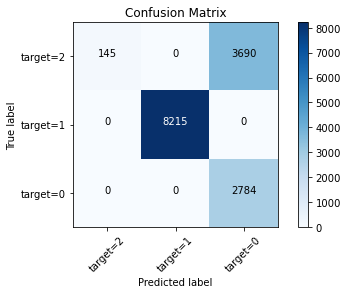

In [65]:
adab = AdaBoostClassifier(learning_rate=0.05)
est, table, params, imp = best_model_class(adab, x_class_train, y_class_train,
                                x_class_valid,y_class_valid,
                                grid_params=[{'n_estimators':[100, 200]}])


In [66]:
est

AdaBoostClassifier(learning_rate=0.05, n_estimators=100)

In [67]:
table

params  mean_test_score  std_test_score  mean_train_score  \
0  {'n_estimators': 100}         0.756581        0.001019          0.756581   
1  {'n_estimators': 200}         0.756581        0.001019          0.756581   

   std_train_score  
0         0.000255  
1         0.000255

In [68]:
params

{'n_estimators': 100}

In [69]:
imp

feat  score
9   (h, a, s, _, a, d, j, u, s, t, a, b, l, e, _, ...   0.35
6   (n, u, m, b, e, r, _, o, f, _, c, o, m, p, a, ...   0.21
5       (n, u, m, b, e, r, _, o, f, _, s, t, o, p, s)   0.17
10                  (h, a, s, _, b, i, c, y, c, l, e)   0.17
0          (p, r, i, c, e, _, i, n, _, c, e, n, t, s)   0.06
7                            (h, a, s, _, w, i, f, i)   0.03
1                   (t, r, a, v, e, l, _, t, i, m, e)   0.01
2                            (d, i, s, t, a, n, c, e)   0.00
3                                  (o, _, c, i, t, y)   0.00
4                                  (d, _, c, i, t, y)   0.00
8                            (h, a, s, _, p, l, u, g)   0.00

* <b>Tuning Random Forest Classifier:</b>

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2784
           1       1.00      1.00      1.00      8215
           2       0.99      1.00      0.99      3835

    accuracy                           1.00     14834
   macro avg       1.00      1.00      1.00     14834
weighted avg       1.00      1.00      1.00     14834



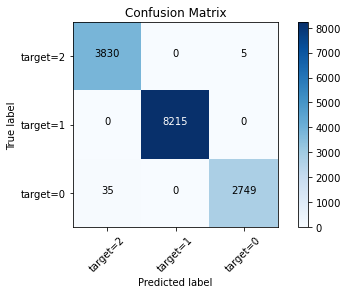

In [70]:
rfc = RandomForestClassifier()
est, table, params, imp = best_model_class(rfc, x_class_train, y_class_train,
                                x_class_valid,y_class_valid,
                                grid_params=[{'n_estimators':[100, 200]}])


In [71]:
est

RandomForestClassifier(n_estimators=200)

In [72]:
table

params  mean_test_score  std_test_score  mean_train_score  \
1  {'n_estimators': 200}         0.997337        0.000379               1.0   
0  {'n_estimators': 100}         0.997270        0.000422               1.0   

   std_train_score  
1              0.0  
0              0.0

In [73]:
params

{'n_estimators': 200}

In [74]:
imp

feat     score
5       (n, u, m, b, e, r, _, o, f, _, s, t, o, p, s)  0.259227
6   (n, u, m, b, e, r, _, o, f, _, c, o, m, p, a, ...  0.226673
7                            (h, a, s, _, w, i, f, i)  0.157845
9   (h, a, s, _, a, d, j, u, s, t, a, b, l, e, _, ...  0.139062
0          (p, r, i, c, e, _, i, n, _, c, e, n, t, s)  0.071741
1                   (t, r, a, v, e, l, _, t, i, m, e)  0.059119
8                            (h, a, s, _, p, l, u, g)  0.045429
2                            (d, i, s, t, a, n, c, e)  0.017409
10                  (h, a, s, _, b, i, c, y, c, l, e)  0.011166
4                                  (d, _, c, i, t, y)  0.007909
3                                  (o, _, c, i, t, y)  0.004419

* <b>Tuning Gaussian Naive Bayes Classifier:</b>

              precision    recall  f1-score   support

           0       0.87      0.75      0.80      2784
           1       0.84      0.93      0.88      8215
           2       0.79      0.69      0.74      3835

    accuracy                           0.83     14834
   macro avg       0.83      0.79      0.81     14834
weighted avg       0.83      0.83      0.83     14834



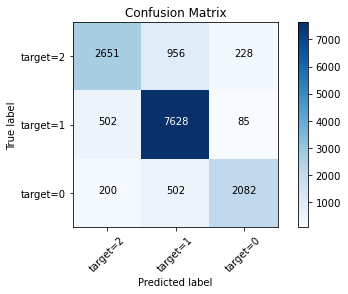

In [75]:
gnb = GaussianNB()
est, table, params, imp = best_model_class(gnb, x_class_train, y_class_train,
                                x_class_valid,y_class_valid,
                                grid_params=[{'var_smoothing':[1e-2, 1e-5,1e-9]}])


In [76]:
est

GaussianNB()

In [77]:
table

params  mean_test_score  std_test_score  \
2  {'var_smoothing': 1e-09}         0.836873        0.002878   
1  {'var_smoothing': 1e-05}         0.791030        0.002840   
0   {'var_smoothing': 0.01}         0.708987        0.004758   

   mean_train_score  std_train_score  
2          0.836835         0.003492  
1          0.791262         0.001869  
0          0.708957         0.005910

In [78]:
params

{'var_smoothing': 1e-09}

* AdaBoost was by far the worst performing model of all 3 with 0.75 accuracy. It also completely failed to predict train transport_type (0.07 f1-score for target 2)
* Naive Bayes had very acceptable results with 0.83 in accuracy and 0.74+ f1-score for each target.
* Random Forest did ridiculously well with an overall accuracy of 1.00. Guessing 100% of the carpooling data correctly which may hint us towards an overfitting of the model caused by 1) the amount of data of carpooling, 2) the fact that all carpooling data are similar to each other having 0 in number of stops and stations so that may lead to an obvious guess 

## GROUP BY

In this section we will be utilizing the groupby method to pinpoint some interesting facts about our data.

In [102]:
ticket.columns

Index(['id', 'company', 'o_station', 'd_station', 'price_in_cents',
       'search_ts', 'middle_stations', 'other_companies', 'o_city', 'd_city',
       'travel_time', 'latitude_city_origin', 'longitude_city_origin',
       'latitude_city_destination', 'longitude_city_destination', 'distance',
       'number_of_stops', 'number_of_companies', 'has_wifi', 'fullname',
       'has_plug', 'has_adjustable_seats', 'has_bicycle', 'transport_type',
       'distance_seg'],
      dtype='object')

First, we are going to show the min/average/max price and travel time for each and every trip and its number of occurence in our data.

In [103]:
o_d_data = ticket.groupby(["o_city","d_city"]).agg({'price_in_cents' : ["mean", "min", "max"], 'travel_time' : ["mean", "min", "max"], "id": "count"})
o_d_data

price_in_cents                 travel_time                     \
                        mean    min    max          mean      min       max   
o_city d_city                                                                 
5      23       20320.000000  18600  22000  37128.000000  31980.0   57240.0   
6      227      11755.000000   9860  13650  49350.000000  44640.0   54060.0   
       504       4042.666667   2000   8920  29844.000000  20160.0   44400.0   
       628       2797.500000   2600   3190  43800.000000  34800.0   52200.0   
       845        864.626866    700   2420   4794.626866   3600.0   15060.0   
...                      ...    ...    ...           ...      ...       ...   
11938  126       4204.861111   3000   5350  26716.666667  19800.0  127200.0   
12124  1064      6950.000000   6000   7900  61800.000000  40200.0   83400.0   
12166  857       5300.000000   5300   5300  78900.000000  78900.0   78900.0   
12190  639        688.888889    600    850   5333.333333   4200.0    9600.0   
       8937      9800.000000   9800   9800  33000.000000  33000.0   33000.0   

                 id  
              count  
o_city d_city        
5      23         5  
6      227        2  
       504       30  
       628        4  
       845      201  
...             ...  
11938  126       72  
12124  1064       2  
12166  857        1  
12190  639       18  
       8937       1  

[1437 rows x 7 columns]

We check for the minimum and maximum distance in order to decide upon segments. We will be going with <200, 201-800 and 801+.

In [82]:
print("distance min = ",ticket["distance"].min())
print("distance max = ",ticket["distance"].max())

distance min =  18.93402206071545
distance m =  1872.2268320519906


In [83]:
ticket.loc[ticket["distance"]<=200,"distance_seg"] = "<200km"
ticket.loc[(ticket["distance"]>200) & (ticket["distance"]<=800),"distance_seg"] = "201-800km"
ticket.loc[ticket["distance"]>800,"distance_seg"] = "801+km"

In [84]:
ticket["distance_seg"].value_counts()

201-800km    58877
<200km       13724
801+km        1567
Name: distance_seg, dtype: int64

Let's visualize the mean price and travel time for each distance segment for each transport type we have.

In [85]:
transp_by_dist = ticket.groupby(["transport_type","distance_seg"]).agg({'price_in_cents' : ["mean"], 'travel_time' : ["mean"]})
transp_by_dist

price_in_cents   travel_time
                                      mean          mean
transport_type distance_seg                             
bus            201-800km       3494.850022  54269.269315
               801+km          6949.950045  99130.027248
               <200km          2182.830918  36837.053140
carpooling     201-800km       3218.064310  17147.272436
               801+km          8626.545455  47160.839161
               <200km          1177.352385   7027.342428
train          201-800km       9124.779489  27639.543515
               801+km         15463.746130  43771.021672
               <200km          3487.900779  15909.840098

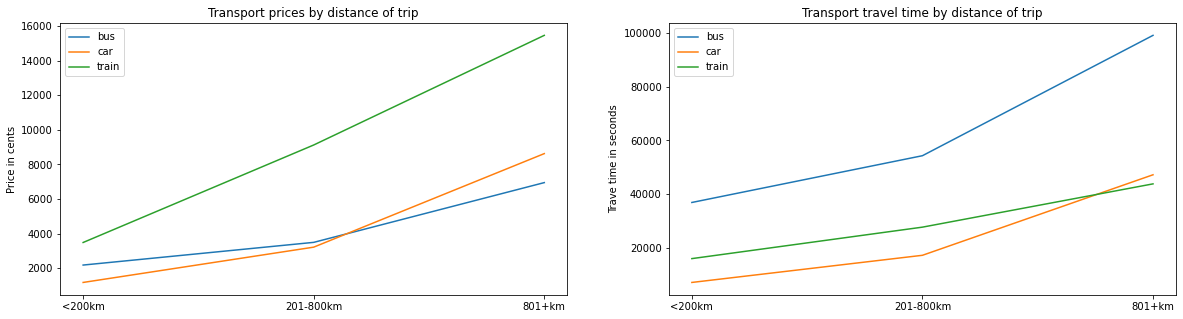

In [86]:
names_bus = [transp_by_dist.index[2][1],transp_by_dist.index[0][1],transp_by_dist.index[1][1]]
values_price_bus = [transp_by_dist["price_in_cents"].values[2][0],transp_by_dist["price_in_cents"].values[0][0],transp_by_dist["price_in_cents"].values[1][0]]
values_tt_bus = [transp_by_dist["travel_time"].values[2][0],transp_by_dist["travel_time"].values[0][0],transp_by_dist["travel_time"].values[1][0]]

names_car = [transp_by_dist.index[5][1],transp_by_dist.index[3][1],transp_by_dist.index[4][1]]
values_price_car = [transp_by_dist["price_in_cents"].values[5][0],transp_by_dist["price_in_cents"].values[3][0],transp_by_dist["price_in_cents"].values[4][0]]
values_tt_car = [transp_by_dist["travel_time"].values[5][0],transp_by_dist["travel_time"].values[3][0],transp_by_dist["travel_time"].values[4][0]]

names_train = [transp_by_dist.index[8][1],transp_by_dist.index[6][1],transp_by_dist.index[7][1]]
values_price_train = [transp_by_dist["price_in_cents"].values[8][0],transp_by_dist["price_in_cents"].values[6][0],transp_by_dist["price_in_cents"].values[7][0]]
values_tt_train = [transp_by_dist["travel_time"].values[8][0],transp_by_dist["travel_time"].values[6][0],transp_by_dist["travel_time"].values[7][0]]

fig, axs = plt.subplots(1,2,figsize=(20,5))
axs[0].plot(names_bus, values_price_bus,label="bus")
axs[0].plot(names_car, values_price_car,label="car")
axs[0].plot(names_train, values_price_train,label="train")
axs[1].plot(names_bus, values_tt_bus,label="bus")
axs[1].plot(names_car, values_tt_car,label="car")
axs[1].plot(names_train, values_tt_train,label="train")

axs[0].set_ylabel("Price in cents")
axs[0].set_title("Transport prices by distance of trip")
axs[0].legend()

axs[1].set_ylabel("Trave time in seconds")
axs[1].set_title("Transport travel time by distance of trip")
axs[1].legend()

plt.show()

Price:
* The train is the most expensive transport type no matter the distance, while carpooling is cheaper than bus for small distances and the opposite for long distances.

Travel Time:
* The bus has by far the highest travel time of all transport types. Carpooling is more time effective for small distances while trains are more time effective in long distances.

Let's now see what is the company that's been booked the most on Tictactrip.

In [89]:
ticket.groupby(["company","transport_type","fullname"]).agg({"id": "count"}).sort_values(by="id")

id
company transport_type fullname                 
33      bus            ExpressBus              1
192     bus            Globtour                1
173     bus            Eurolines UK            3
12      bus            Student Agency          5
10      bus            Deinbus.de              9
8381    train          Intercités de Nuit     14
8387    bus            Vatry                  16
216     bus            Navette de Vatry       16
8379    bus            Navette Keolis        170
71      bus            National Express      252
8382    train          Eurostar              509
8372    bus            Eurolines             725
8384    train          Thalys                796
8371    bus            Isilines             1607
8377    train          Intercités           2193
9       bus            Ouibus               3560
8380    train          TER                  6763
13      bus            Flixbus              7433
8376    train          TGV                  8654
8385    carpooling     Blablacar           41441

Carpooling is by far the transport type that is looked upon the most with 41441 iterations in our data. TGV and Flixbus are the most popular train and bus companies among Tictactrip users.

## Graph

In [92]:
import networkx as nx
G = nx.Graph()

In [93]:
o =ticket["o_city"]
d =ticket["d_city"]
all_cities =list(pd.concat([o, d], ignore_index=True))
# nodes = np.concatenate(o,d)
nodes = set(all_cities)
edges = list(o_d_data.index)

for node in nodes:
    G.add_node(node,weight=all_cities.count(node))
G.add_edges_from(edges)

In [99]:
# Here we remove the cities with less than 300 occurences so that we get a clear graph
toremove = []
for (u, d) in G.nodes(data=True):
    if d["weight"]<300:
        toremove.append(u)
        

G.remove_nodes_from(toremove)
len(G.nodes())

52

In [100]:
weights = []
for (u, d) in G.nodes(data=True):
    weights.append(d["weight"]*5)
    



{11: Text(-171.06206885858418, -304.9655483588476, 'aix-en-provence'),
 23: Text(-114.92101742976284, 261.2972406933854, 'amsterdam'),
 28: Text(288.55292568157233, -312.8012087055931, 'angers'),
 33: Text(108.18660444851851, -605.0491992733754, 'annecy'),
 57: Text(51.893291794942876, -364.04188343814445, 'avignon'),
 85: Text(223.53722937261395, 751.6564965166073, 'bayonne'),
 102: Text(-272.5506380159017, 260.19050888079636, 'besancon'),
 109: Text(-446.2808317518646, 504.1469241525385, 'biarritz'),
 126: Text(-176.26985280756372, 36.17439125889751, 'bordeaux'),
 2181: Text(321.41587563618924, -169.40640695820116, 'paris-aeroport-orly'),
 134: Text(-493.25599786968627, 275.8033212808698, 'bourges'),
 148: Text(-370.58145455891747, -390.0801790111937, 'brest'),
 168: Text(-224.81496050457775, -412.435428280596, 'caen'),
 173: Text(112.09978445318757, 335.67449155530085, 'cannes'),
 186: Text(-759.4772205262612, 227.41713204302656, 'chambery'),
 200: Text(-365.11289299522736, -28.2725

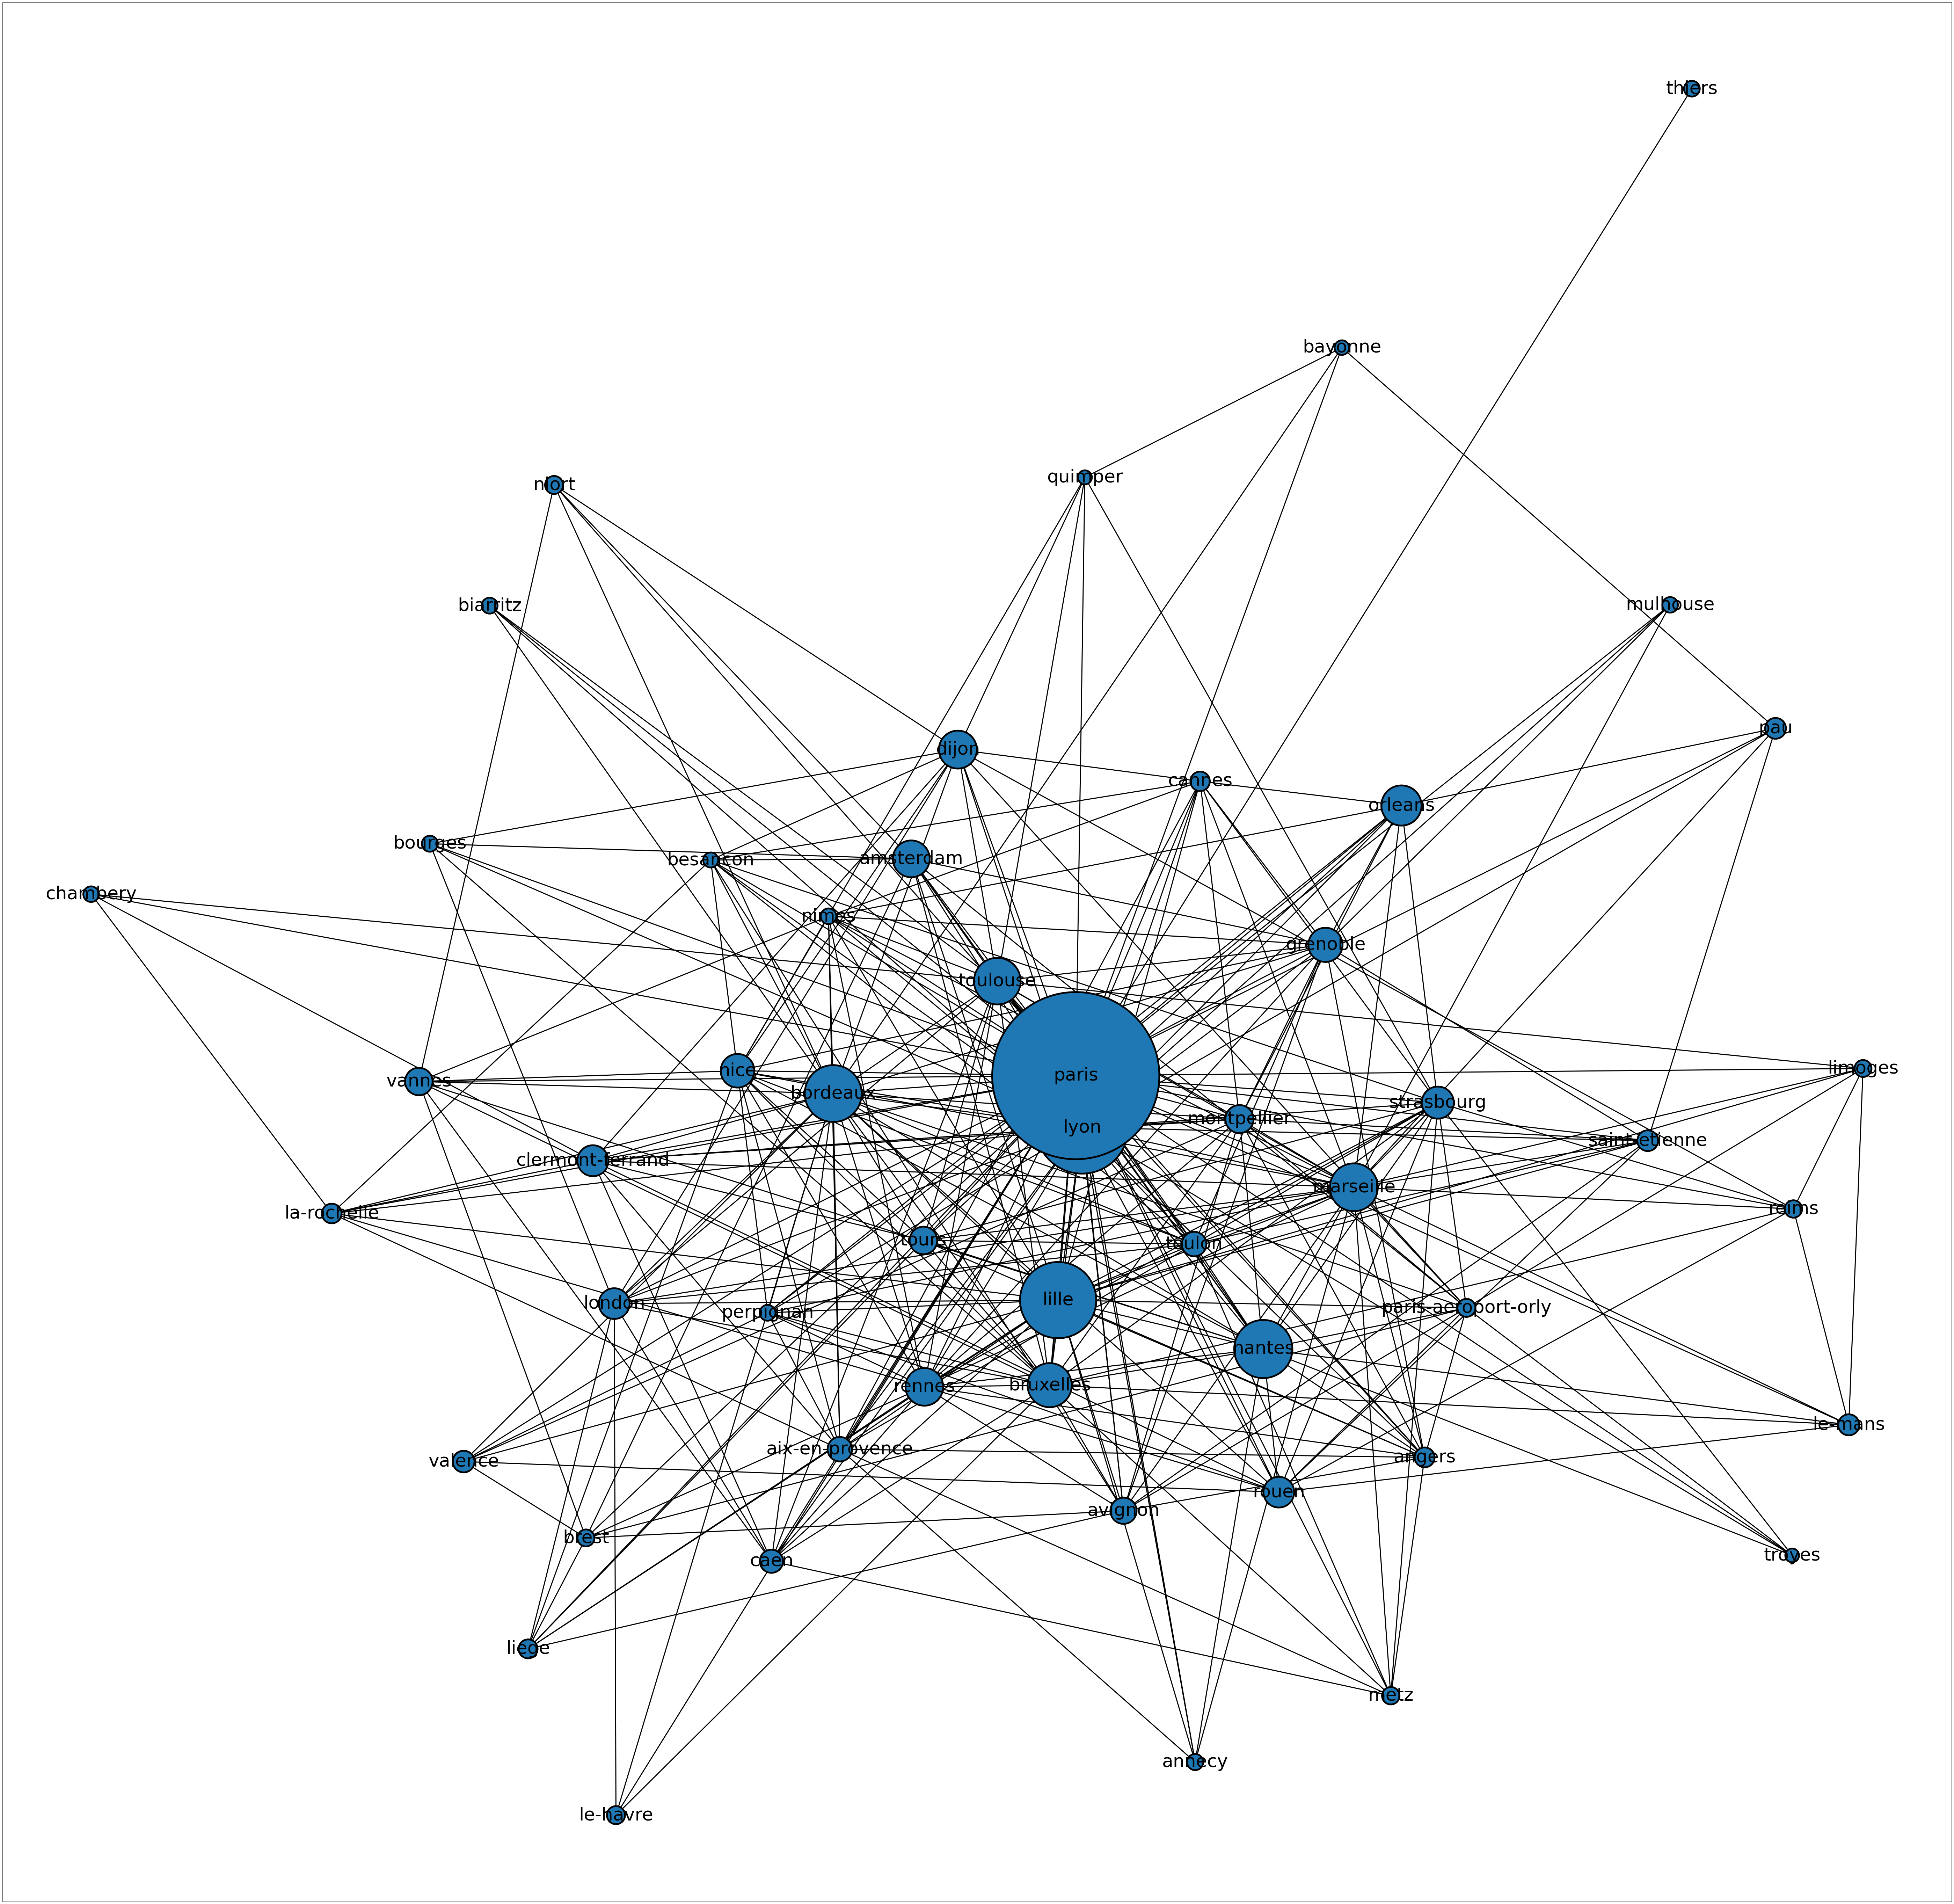

In [101]:
plt.figure(figsize=(100,100))

labeldict = {}
for (u,d) in G.nodes(data=True):
    labeldict[u] = cities[cities["id"]==u]["unique_name"].values[0]
    
    
pos = nx.spring_layout(G,seed=7)
for i in pos:
    pos[i][0] = pos[i][0] * 1000 # x coordinate
    pos[i][1] = pos[i][1] * 1000 # y coordinate# positions for all nodes - seed for reproducibility
nds_draw = nx.draw_networkx_nodes(G, pos, node_size=weights,edgecolors="black",linewidths=5)
# nds_draw.set_edgecolor('r')

nx.draw_networkx_edges(G, pos, width=3)
nx.draw_networkx_labels(G, pos,labels=labeldict, font_size=52, font_family="sans-serif")


In this graph we can clearly see that Paris, Lyon and Lille are the most common cities in our data while chambery for example which is on the edge of the graph is way less present. We can also see the city that are connected to each other (Vannes, La Rochelle etc... for Chambery)